## Portfolio Part 3

In this Portfolio task you will continue working with the movielens data collected by the GroupLens Research Project at the University of Minnesota. The columns in the dataset are a little bit different from the ones provided in the previous Portfolio tasks, where the 'rating' column is replaced by the 'feedback' column. There are two values regarding the 'feedback' with 1 indicating the user likes the corresponding movie; otherwise 0. 

The header of the csv file is shown below. 

| userId | age | gender | occupation| movieId | feedback | genre | timestamp |
    | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | 
    
#### Description of Fields

* __userId__ - the user's id
* __age__ - the user's age
* __gender__ - the user's gender
* __occupation__ - the user's occupation
* __movieId__ - the movie's id
* __feedback__ - the user's feedback towards the movie (1 means 'like'; 0 means 'dislike')
* __genre__ - the genre of the movie
* __timestamp__ - the timestamp indicating when the user rated the movie

Note that, a same user (i.e., a same userId) corresponds to a same age/gender/occupation; a same movie (i.e., a same movieId) corresponds to a same genre; a same user (i.e., a same userId) may like multiple movies and a same movie (i.e., a same movieId) may be preferred by multiple users.


Your high level goal in this notebook is to try to build and evaluate predictive models for feedback from available features - predict the value of the __feedback__ field in the data from some of the other fields. Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.

Note: you are not being evaluated on the ___accuracy___ of the model but on the ___process___ that you use to generate it. Please use a ___simple Logistic Regression model___ and ___one of the more advanced methods___ covered in recent weeks. Accordingly, discuss the performance of the simple and advanced methods.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE

In [3]:
df = pd.read_csv('files/movielens_data_feedback.csv')
df.head(10)

,userId,age,gender,occupation,movieId,feedback,genre,timestamp
0,196,49,M,writer,242,0,Comedy,881250949
1,186,39,F,executive,302,0,Crime,891717742
2,22,25,M,writer,377,0,Children,878887116
3,244,28,M,technician,51,0,Romance,880606923
4,166,47,M,educator,346,0,Drama,886397596
5,298,44,M,executive,474,1,War,884182806
6,115,31,M,engineer,265,0,Action,881171488
7,253,26,F,librarian,465,1,Adventure,891628467
8,305,23,M,programmer,451,0,Romance,886324817
9,6,42,M,executive,86,0,Drama,883603013


### Data exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   userId      100000 non-null  int64 
 1   age         100000 non-null  int64 
 2   gender      100000 non-null  object
 3   occupation  100000 non-null  object
 4   movieId     100000 non-null  int64 
 5   feedback    100000 non-null  int64 
 6   genre       100000 non-null  object
 7   timestamp   100000 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 6.1+ MB


In [5]:
print(df['feedback'].value_counts())

1    55375
0    44625
Name: feedback, dtype: int64


[Text(0.5, 1.0, 'Rating distribution by gender')]

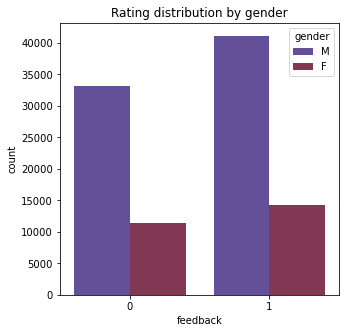

In [6]:
plt.figure(figsize=(5,5))
sns.countplot(x='feedback', data = df, hue='gender', palette = 'twilight').set(title = 'Rating distribution by gender')

The number of male voters is significantly higher than the number of female voters, in terms of both negative and positive feedback. Besides, it shows that there are more movies that receive positive feedback from audiences than movies that receive 'dislikes'. This indicates that the views tend to give good feedback for the movies. 

[Text(0.5, 1.0, 'Age - Feedback boxplot')]

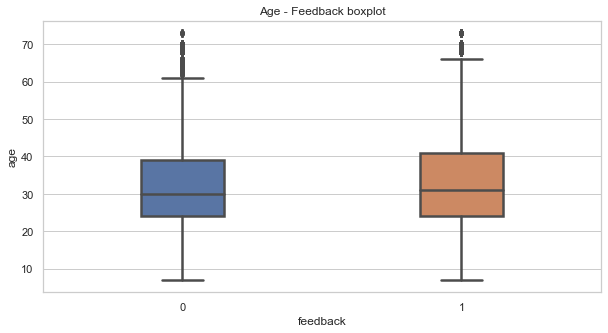

In [7]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,5))

sns.boxplot(y=df.age, x=df.feedback, width = 0.3, linewidth = 2.5).set(title ='Age - Feedback boxplot')

The median age among the users is around 30 years. Age range for users who give 'dislike' is slightly smaller than users who give 'like' for the movies, which suggests that older people tend to be easier when giving feedbacks on movies.

### Data preparation 

In [8]:
#convert gender to numerical values
df['gender'] = df['gender'].astype('category')
df['gender'] = df['gender'].cat.codes

#convert occuptaion to numerical values
df['occupation'] = df['occupation'].astype('category')
df['occupation'] = df['occupation'].cat.codes

#convert genre to numerical values
df['genre'] = df['genre'].astype('category')
df['genre'] = df['genre'].cat.codes

In [9]:
df.head()

,userId,age,gender,occupation,movieId,feedback,genre,timestamp
0,196,49,1,20,242,0,4,881250949
1,186,39,0,6,302,0,5,891717742
2,22,25,1,20,377,0,3,878887116
3,244,28,1,19,51,0,13,880606923
4,166,47,1,3,346,0,7,886397596


### Split Training and Testing Data

In [10]:
feature_cols = np.array(['age', 'gender', 'occupation','genre', 'timestamp'])

X = df[feature_cols]
y = df['feedback']

# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=142)

### Regression Model

In [11]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [12]:
# Doing predictions on train and test set
logreg_pred_train = logreg.predict(X_train)
logreg_pred_test = logreg.predict(X_test)

logreg_train_accuracy = accuracy_score(logreg_pred_train, y_train)
print('Training accuracy is: ', logreg_train_accuracy)

logreg_test_accuracy = accuracy_score(logreg_pred_test, y_test)
print('Testing accuracy is: ', logreg_test_accuracy)

Training accuracy is:  0.5525555555555556
Testing accuracy is:  0.5645


Result of Regression Model using all available features. From the result, we may need to think about choosing the best features in order to optimize our prediction

### K-Nearest Neighbors Model

In [13]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors =10)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [14]:
# Doing predictions on train and test set
knn_pred_train = knn.predict(X_train)
knn_pred_test = knn.predict(X_test)

knn_train_accuracy = accuracy_score(knn_pred_train, y_train)
print('Training accuracy is: ', knn_train_accuracy)

knn_test_accuracy = accuracy_score(knn_pred_test, y_test)
print('Testing accuracy is: ', knn_test_accuracy)

Training accuracy is:  0.7256333333333334
Testing accuracy is:  0.6617


Result of KNN  model using all available features is higher than what we get from employing Regression Model. However, our training accuracy is significantly higher than testing accuracy, which suggests that our model is overfitting. We may need to find the best features and our choice of 'k' value in order to get the most optimal prediction result. 

In [15]:
from sklearn.model_selection import cross_val_score

clf = KNeighborsClassifier(n_neighbors = 4)
scores = cross_val_score(clf, X, y, cv=10)
print('Accuracy for each round: \n', scores)
print('Average accuracy: %.4f +- %.4f' % (scores.mean(), scores.std()))

Accuracy for each round: 
 [0.6488 0.6389 0.6388 0.6399 0.6327 0.6426 0.6251 0.6322 0.6337 0.6327]
Average accuracy: 0.6365 +- 0.0063


Create a KNN classifier model and use k-fold cross validation for testing accuracy estimation will give us an idea of the accuracy we should obtain from employing KNN model. 

In [16]:
from sklearn.model_selection import GridSearchCV
# Define search space for parameters
parameter_grid = {'n_neighbors': range(1, 21)}

# Create the machine learning model
knn_clf = KNeighborsClassifier()
clf = GridSearchCV(knn_clf, parameter_grid, scoring='accuracy', cv=10)
clf.fit(X, y)

# Identify the best parameter(s)
print('Best K value: ', clf.best_params_['n_neighbors'])
print('The accuracy: ', clf.best_score_)

Best K value:  11
The accuracy:  0.66165


It is suggested that our KNN model will give the most accurate prediction when k value is set to 11. 

### Feature Selection

In [17]:
feature_score = pd.DataFrame(columns=["Feature", "Accuracy Score"])
for feature in X_train.columns:
    knn = KNeighborsClassifier(n_neighbors = 11)
    knn.fit(X_train[[feature]], y_train)
    knn.score(X_test[[feature]], y_test)
    feature_score = feature_score.append({"Feature": feature, "Accuracy Score": knn.score(X_test[[feature]], y_test)}, ignore_index=True)

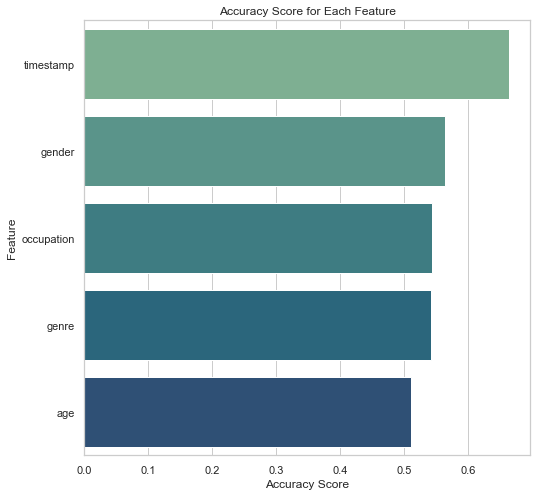

In [18]:
feature_score = feature_score.sort_values("Accuracy Score", ascending = False)
plt.figure(figsize=(8,8))
ax = sns.barplot(data=feature_score,
                 x="Accuracy Score",
                 y="Feature", 
                 palette = "crest")
ax.set_title("Accuracy Score for Each Feature")
plt.show()

Graphing the accuracy of each feature in K-Nearest Neighbors. From the graph we can see that 'timestamp' and 'gender' are the 2 features that give us the highest accuracy. While 'age' is underperforming in our KNN model

In [19]:
best_features = list(feature_score[feature_score["Accuracy Score"] > 0.6].copy()["Feature"])

knn = KNeighborsClassifier(n_neighbors = 11)
knn.fit(X_train[best_features], y_train)

knn_training_accuracy = knn.score(X_train[best_features], y_train)
print("Accuracy on training set:", knn_training_accuracy)

knn_testing_accuracy = knn.score(X_test[best_features], y_test)
print("Accuracy on testing set:", knn_testing_accuracy)

Accuracy on training set: 0.7228
Accuracy on testing set: 0.6649


The accuracy on training set is still higher than on testing set, which suggests that our model is still overfitting even when we apply the optimal k value and optimal features.

In [20]:
rfe = RFE(logreg, 3)
rfe_model = rfe.fit(X_train, y_train)
print("Number of features: ", rfe_model.n_features_)
print("Selected features:", feature_cols[rfe.get_support()])
print("Features ranking: ", rfe_model.ranking_)

Number of features:  3
Selected features: ['age' 'genre' 'timestamp']
Features ranking:  [1 3 2 1 1]


For regression model, when it comes to feature selections, it is noticed that 'age', 'genre' and 'timestamp' have the most influence on our model performance. 

In [21]:
# test the model
y_hat_train = rfe.predict(X_train)
y_hat_test = rfe.predict(X_test)
logreg_training_accuracy = accuracy_score(y_train, y_hat_train)
print('Training accuracy is: ', logreg_training_accuracy)

logreg_testing_accuracy = accuracy_score(y_test, y_hat_test)
print('Testing accuracy is: ', logreg_testing_accuracy)

Training accuracy is:  0.5525555555555556
Testing accuracy is:  0.5645


Regression model performs better on the testing set, though the accuracy is fairly low.

### Conclusion

In [22]:
models = {
    'Model': ['Logistic Regression', 'K-Nearest Neighbor'],
    'Training Accuracy': [logreg_training_accuracy, knn_training_accuracy],
    
    'Testing Accuracy': [logreg_testing_accuracy, knn_testing_accuracy],
    
}

accuracy = pd.DataFrame(models)
accuracy

,Model,Training Accuracy,Testing Accuracy
0,Logistic Regression,0.552556,0.5645
1,K-Nearest Neighbor,0.722800,0.6649


<AxesSubplot:title={'center':'Accuracies across models'}, xlabel='Model'>

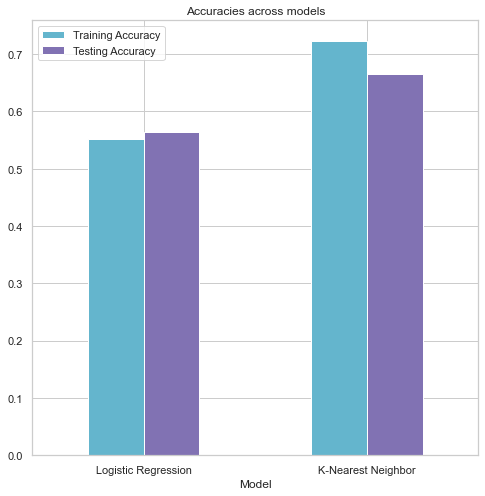

In [24]:
accuracy.plot(kind='bar',x='Model', y=['Training Accuracy', 'Testing Accuracy'], figsize= (8,8), title = "Accuracies across models", color = ['c', 'm'], rot = 0)

#### Summary:
* Overall, KNN model gives higher accuracy than Logistic Regression model
* Logistic regression model performs better on the testing set
* K-Nearest Neighbor model performs poorer on the testing set
* The variation on the performance with different model suggests that the models are not well trained with these input features. Or in other words, these input features are not useful for predicting feedback from users. 